In [2]:
import numpy as np
import pandas as pd

import os
import math
import random
import cv2

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image

import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
import keras.backend.tensorflow_backend as K

from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score

%matplotlib inline

# Quick Look at the Data

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
image_name    40479 non-null object
tags          40479 non-null object
dtypes: object(2)
memory usage: 632.6+ KB


In [5]:
df.describe()

,image_name,tags
count,40479,40479
unique,40479,458
top,train_3158,clear primary
freq,1,13636


In [6]:
df['tag_set'] = df['tags'].map(lambda s: set(s.split(' ')))

tags = set()
for t in df['tags']:
    s = set(t.split(' '))
    tags = tags | s

tag_list = list(tags)
tag_list.sort()
tag_columns = ['tag_' + t for t in tag_list]
for t in tag_list:
    df['tag_' + t] = df['tag_set'].map(lambda x: 1 if t in x else 0)

In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 20 columns):
image_name               40479 non-null object
tags                     40479 non-null object
tag_set                  40479 non-null object
tag_agriculture          40479 non-null int64
tag_artisinal_mine       40479 non-null int64
tag_bare_ground          40479 non-null int64
tag_blooming             40479 non-null int64
tag_blow_down            40479 non-null int64
tag_clear                40479 non-null int64
tag_cloudy               40479 non-null int64
tag_conventional_mine    40479 non-null int64
tag_cultivation          40479 non-null int64
tag_habitation           40479 non-null int64
tag_haze                 40479 non-null int64
tag_partly_cloudy        40479 non-null int64
tag_primary              40479 non-null int64
tag_road                 40479 non-null int64
tag_selective_logging    40479 non-null int64
tag_slash_burn           40479 non-null int64
tag_water     

,tag_agriculture,tag_artisinal_mine,tag_bare_ground,tag_blooming,tag_blow_down,tag_clear,tag_cloudy,tag_conventional_mine,tag_cultivation,tag_habitation,tag_haze,tag_partly_cloudy,tag_primary,tag_road,tag_selective_logging,tag_slash_burn,tag_water
count,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000
mean,0.304800,0.008375,0.021221,0.008202,0.002421,0.696732,0.057561,0.002470,0.110601,0.090467,0.066578,0.179130,0.934806,0.199511,0.008399,0.005163,0.179402
std,0.460328,0.091131,0.144122,0.090193,0.049145,0.459676,0.232914,0.049642,0.313641,0.286853,0.249292,0.383466,0.246871,0.399638,0.091264,0.071670,0.383693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.head()

,image_name,tags,tag_set,tag_agriculture,tag_artisinal_mine,tag_bare_ground,tag_blooming,tag_blow_down,tag_clear,tag_cloudy,tag_conventional_mine,tag_cultivation,tag_habitation,tag_haze,tag_partly_cloudy,tag_primary,tag_road,tag_selective_logging,tag_slash_burn,tag_water
0,train_0,haze primary,"{haze, primary}",0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,"{water, clear, agriculture, primary}",1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,"{clear, primary}",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,"{clear, primary}",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,"{habitation, clear, road, agriculture, primary}",1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [9]:
df[tag_columns].sum()

tag_agriculture          12338
tag_artisinal_mine         339
tag_bare_ground            859
tag_blooming               332
tag_blow_down               98
tag_clear                28203
tag_cloudy                2330
tag_conventional_mine      100
tag_cultivation           4477
tag_habitation            3662
tag_haze                  2695
tag_partly_cloudy         7251
tag_primary              37840
tag_road                  8076
tag_selective_logging      340
tag_slash_burn             209
tag_water                 7262
dtype: int64

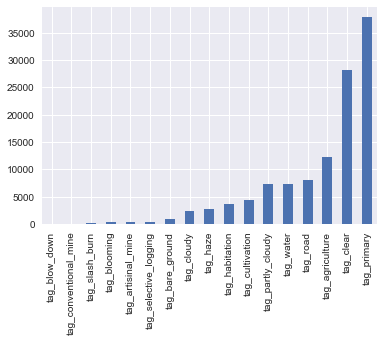

In [10]:
df[tag_columns].sum().sort_values().plot.bar()

In [11]:
tags_count = df.groupby('tags').count().sort_values(by='image_name', ascending=False)['image_name']
print('There are {} unique tag combinations'.format(len(tags_count)))
print()
print(tags_count)

There are 458 unique tag combinations

tags
clear primary                                                                13636
partly_cloudy primary                                                         3629
cloudy                                                                        1968
clear primary water                                                           1850
agriculture clear primary road                                                1680
agriculture clear primary                                                     1626
haze primary                                                                  1469
agriculture clear cultivation primary                                         1170
agriculture clear habitation primary road                                     1125
agriculture clear primary water                                                712
agriculture partly_cloudy primary                                              692
partly_cloudy primary water                

In [12]:
from textwrap import wrap

def display(images, cols=None, maxcols=10, width=16, titles=None):
    if cols is None:
        cols = len(images)
    n_cols = cols if cols < maxcols else maxcols
    plt.rc('axes', grid=False)
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(
                fig1,
                111,
                nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                axes_pad=(0.1, 0.6)
            )

    for index, img in enumerate(images):
        grid1[index].grid = False
        if titles is not None:
            grid1[index].set_title('\n'.join(wrap(titles[index], width=25)))
        if len(img.shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(img)

In [81]:
from skimage import io

def load_image(filename, resize=True, folder='train-jpg'):
    img = io.imread('{}/{}.jpg'.format(folder, filename))
    #print(img.shape)
    #r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    #print(nir.min(), nir.max())
    if resize:
        img = cv2.resize(img, (224, 224))
    return np.array(img)

def mean_normalize(img):
    work = img.copy().astype(np.float32)
    for c in range(work.shape[-1]):
        w = work[...,c]
        work[...,c] = (w - w.mean()) / (w.max() - w.min())
    return work

def normalize(img):
    return img / 127.5 - 1

def enhance(img):
    work = img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for c in range(work.shape[-1]):
        work[..., c] = clahe.apply(work[..., c])
    return work

def unnormalize(img):
    work = img.copy()
    for c in range(work.shape[-1]):
        w = work[...,c]
        work[...,c] = 255 * (w - w.min()) / (w.max() - w.min())
    return work.astype(np.uint8)

In [64]:
#nir = sample_images[0][:,:,3]
#nir.max()

(224, 224, 3)


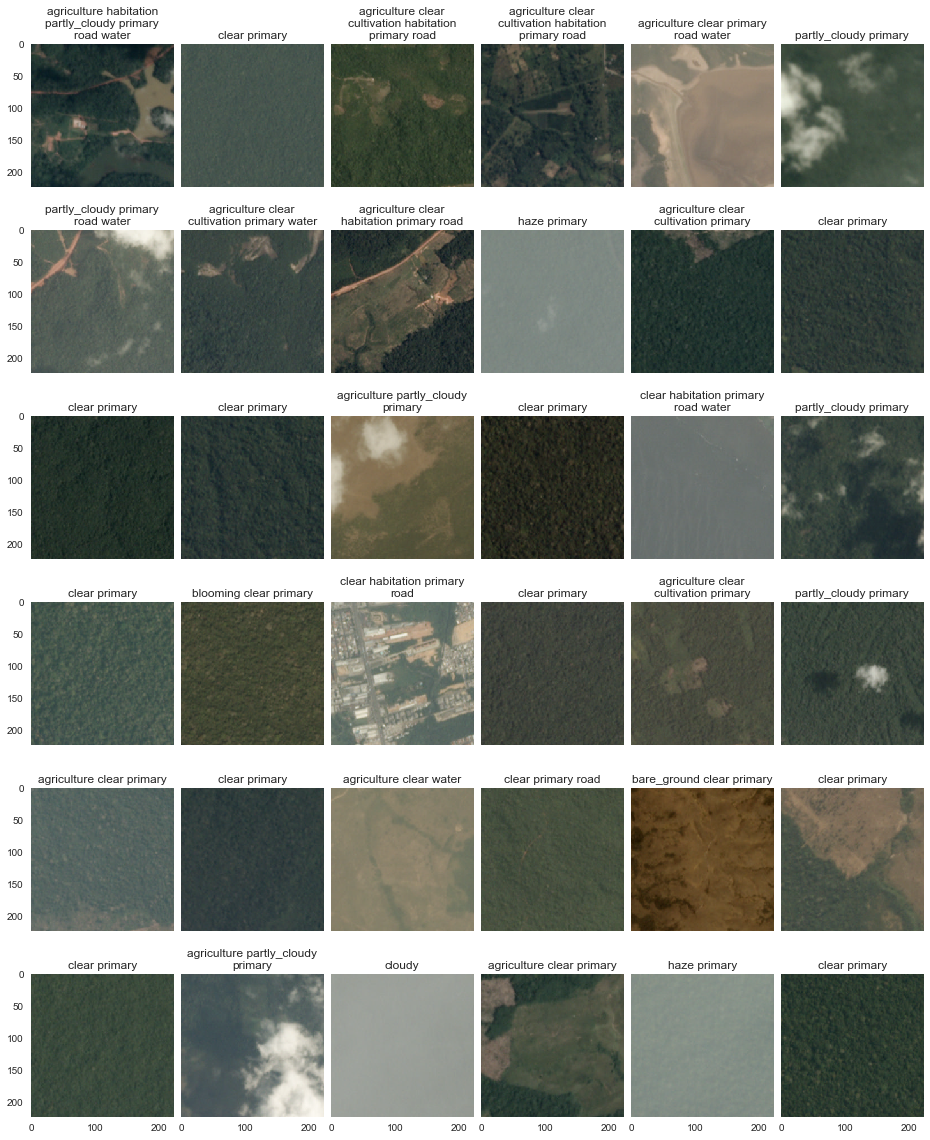

In [87]:
samples = df.sample(36)
sample_images = [load_image(fn) for fn in samples['image_name']]
INPUT_SHAPE = sample_images[0].shape
print(INPUT_SHAPE)
display(
    sample_images,
    cols=6,
    titles=[t for t in samples['tags']]
)

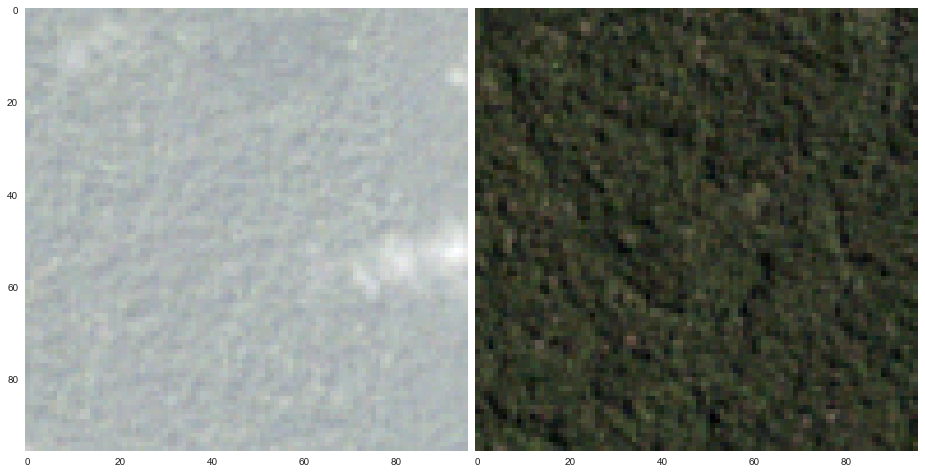

In [66]:
def my_preprocess(img):
    img = normalize(img)
    return img

preprocess = my_preprocess

si = np.array(sample_images[:2])
display(unnormalize(preprocess(si)))

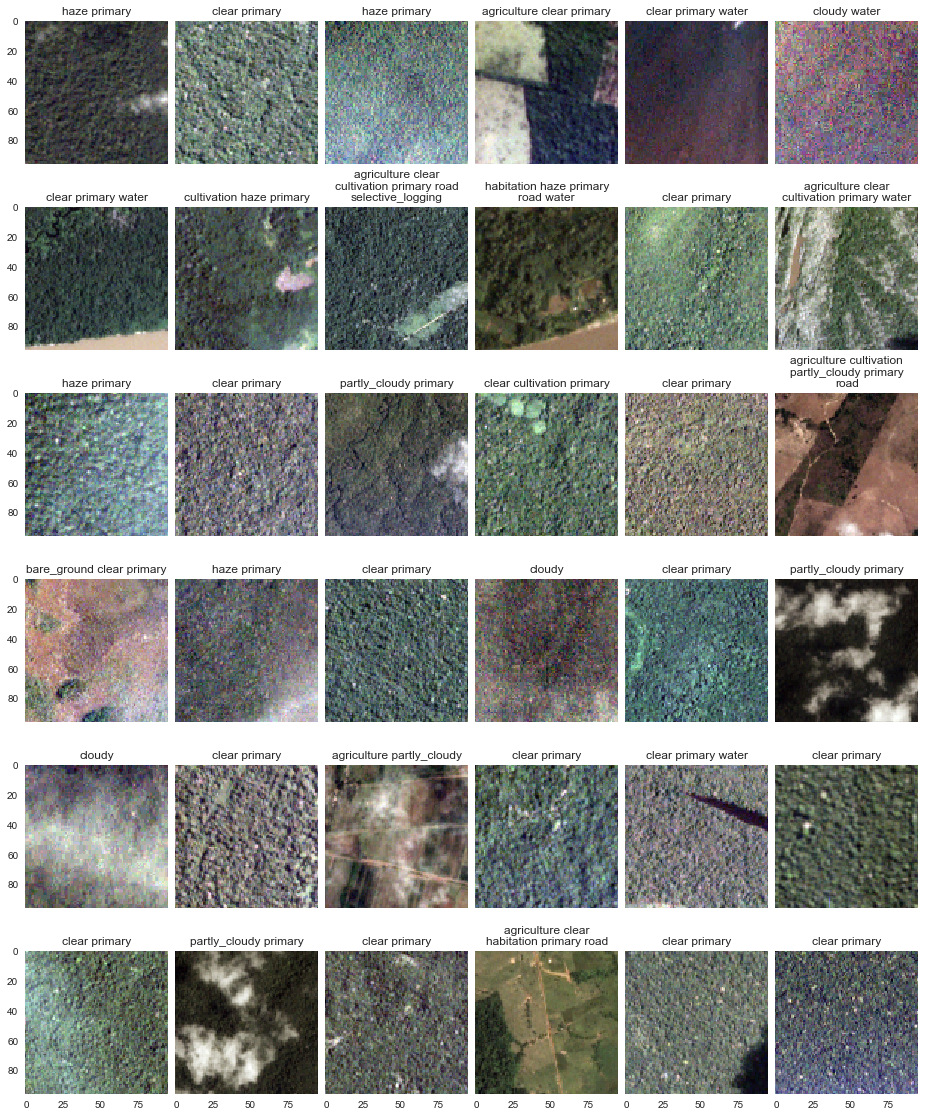

In [67]:
display(
    [unnormalize(preprocess(img)) for img in sample_images],
    cols=6,
    titles=[t for t in samples['tags']]
)

# Learn

In [82]:
# df_train <- select up to 300 samples per tag
samples_per_tag = 300
df_train = []
for t in tag_columns:
    if t in ('tag_primary', 'clear'):
        continue
    tag_condition = df[t] == 1
    take = min(samples_per_tag, tag_condition.sum())
    df_train.append(df[tag_condition].sample(take).values)

df_train = np.concatenate(df_train)
df_train = pd.DataFrame(df_train)
df_train.columns = df.columns

df_train[tag_columns].sum()
df_train = df

In [88]:
X = df_train['image_name'].values
y = df_train[tag_columns].values

n_features = 1
n_classes = y.shape[1]

X, y = shuffle(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

print('We\'ve got {} feature rows and {} labels'.format(len(X_train), len(y_train)))
print('Each row has {} features'.format(n_features))
print('and we have {} classes'.format(n_classes))
assert(len(y_train) == len(X_train))
print('We use {} rows for training and {} rows for validation'.format(len(X_train), len(X_valid)))
print('Each image has the shape:', INPUT_SHAPE)
print('So far, so good')

We've got 36431 feature rows and 36431 labels
Each row has 1 features
and we have 17 classes
We use 36431 rows for training and 4048 rows for validation
Each image has the shape: (224, 224, 3)
So far, so good


In [89]:
print('Memory usage (train) kB', X_train.nbytes//(1024))
print('Memory usage (valid) kB', X_valid.nbytes//(1024))

Memory usage (train) kB 284
Memory usage (valid) kB 31


In [122]:
def fliplr(img, y):
    return np.fliplr(img.copy()), y

def flipud(img, y):
    return np.flipud(img.copy()), y

def adjust_brightness(img, y, amount):
    result = img.astype(np.int16)
    result += amount
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result, y

def _augment(X, y):
    new_X, new_y = [], []
    def add(nx, ny):
        new_X.append(nx)
        new_y.append(ny)

    amount = int(random.uniform(5, 15))
    add(X, y)
    add(*fliplr(X, y))
    add(*flipud(X, y))
    add(*flipud(*fliplr(X, y)))
    #add(*adjust_brightness(*fliplr(X, y), amount))
    #add(*adjust_brightness(*flipud(X, y), -amount))
    add(*adjust_brightness(*(X, y), amount))
    add(*adjust_brightness(*(X, y), -amount))

    return new_X, new_y

def generator(X, y, augment=False, batch_size=32):
    X_copy, y_copy = X, y
    while True:
        for i in range(0, len(X_copy), batch_size):
            X_result, y_result = [], []
            for x, y in zip(X_copy[i:i+batch_size], y_copy[i:i+batch_size]):
                rx, ry = load_image(x), y

                if augment:
                    rx, ry = _augment(rx, ry)
                else:
                    rx, ry = [rx], [ry]

                rx = np.array([preprocess(x) for x in rx])
                ry = np.array(ry)
                X_result.append(rx)
                y_result.append(ry)
            X_result, y_result = np.concatenate(X_result), np.concatenate(y_result)
            yield shuffle(X_result, y_result)
        X_copy, y_copy = shuffle(X_copy, y_copy)

In [91]:
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def f2score(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

# ---------------------------------- #

In [92]:
SCORING = fbeta
SCORING_STR = SCORING.__name__

In [110]:
def my_model():
    model = Sequential()

    model.add(Conv2D(64, (8, 8), strides=(2, 2), input_shape=INPUT_SHAPE, activation='elu'))
    model.add(BatchNormalization())

    model.add(Conv2D(96, (8, 8), strides=(2, 2), activation='elu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='elu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='elu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(Dense(n_classes, activation='sigmoid'))
    return model

def resnet_model():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    
    for layer in base.layers:
        layer.trainable = False
    
    x = Flatten()(base.output)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    preds = Dense(n_classes, activation='sigmoid')(x)
    
    head = Model(inputs=base.input, outputs=preds)

    return head

def vgg19_model():
    base = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    
    for layer in base.layers:
        layer.trainable = False
    
    x = Flatten()(base.output)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    preds = Dense(n_classes, activation='sigmoid')(x)
    
    head = Model(inputs=base.input, outputs=preds)

    return head

model = vgg19_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[SCORING, 'accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [111]:
filepath='vgg19-weights-{epoch:02d}-{val_' + SCORING_STR + ':.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_' + SCORING_STR, verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [126]:
EPOCHS = 4
BATCH = 64
PER_EPOCH = 128
print('Steps needed:', (len(y_train) // BATCH))

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

history = model.fit_generator(
    generator(X_train, y_train, augment=False, batch_size=BATCH),
    steps_per_epoch=PER_EPOCH,
    epochs=EPOCHS,
    validation_data=generator(X_valid, y_valid, batch_size=BATCH),
    validation_steps=len(y_valid)//(2*BATCH),
    callbacks=callbacks_list,
    pickle_safe=False
)

Steps needed: 569
Epoch 1/4
128/128 [==============================] - 77s - loss: 0.1232 - fbeta: 0.8253 - acc: 0.9520 - val_loss: 0.1235 - val_fbeta: 0.8249 - val_acc: 0.9519
Epoch 2/4
128/128 [==============================] - 73s - loss: 0.1267 - fbeta: 0.8179 - acc: 0.9499 - val_loss: 0.1227 - val_fbeta: 0.8268 - val_acc: 0.9516
Epoch 3/4
128/128 [==============================] - 73s - loss: 0.1273 - fbeta: 0.8206 - acc: 0.9500 - val_loss: 0.1245 - val_fbeta: 0.8215 - val_acc: 0.9510
Epoch 4/4
128/128 [==============================] - 74s - loss: 0.1254 - fbeta: 0.8250 - acc: 0.9510 - val_loss: 0.1224 - val_fbeta: 0.8181 - val_acc: 0.9511


In [104]:
#model.save('model.h5')
model.load_weights('resnet-weights-00-0.866.hdf5')

In [105]:
%%time
from tqdm import tqdm

X_test = os.listdir('test-jpg')
X_test = [fn.replace('.jpg', '') for fn in X_test]

result = []
TEST_BATCH = 24
for i in tqdm(range(0, len(X_test), TEST_BATCH)):
    X_batch = X_test[i:i+TEST_BATCH]
    X_batch = np.array([preprocess(load_image(fn, folder='test-jpg')) for fn in X_batch])
    p = model.predict(X_batch)
    result.append(p)
#print(result)

100%|██████████| 1695/1695 [09:38<00:00,  3.25it/s]

CPU times: user 6min 53s, sys: 1min 53s, total: 8min 47s
Wall time: 9min 39s


In [106]:
r = np.concatenate(result)
r = r > 0.5
r

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [107]:
table = []
for row in r:
    t = []
    for b, v in zip(row, tag_columns):
        if b:
            t.append(v.replace('tag_', ''))
    table.append(' '.join(t))
#list(zip(X_test, table))

In [108]:
df_pred = pd.DataFrame.from_dict({'image_name': X_test, 'tags': table})
df_pred.to_csv('submission_20170506.csv', index=False)